<h1>Using ImgAlignNet for image classification and patch capture</h1>

This notebook is a demo for showing how the ImgAlignNet works after training.

<h2>1. Preparetion</h2>
As the initial step, several modules and functions should be imported and implemented.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_s_curve
import torch
from torch import nn

import os, sys
import repo_AE as module
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Rectangle

from torch.nn import functional as F

In [2]:
def showOneFigWithGrid(image_tensor, grid_size=(16, 16), lineColor='black', alphaGrid=0.5, 
                       alphaRect=0.6,highlight=None, cmap=None, figsize=(8,8),facecolor=None,
                      title=None,showTitle=True,save=False):
    to_pil = ToPILImage()
    image_pil = to_pil(image_tensor.squeeze(0))
    
    plt.figure(figsize=figsize)
    
    plt.imshow(image_pil, cmap=cmap)

    height, width = image_tensor.shape[-2], image_tensor.shape[-1]

    for i in range(0, height, grid_size[0]):
        if i == 0:
            continue
        plt.axhline(y=i, color=lineColor, linestyle='-',alpha=alphaGrid)
    for j in range(0, width, grid_size[1]):
        if j == 0:
            continue
        plt.axvline(x=j, color=lineColor, linestyle='-',alpha=alphaGrid)

    textBias = (grid_size[1]/10,grid_size[0]/3*2)
    if highlight:
        for (row, col, color, text) in highlight:
            rect = Rectangle((col*grid_size[1], row*grid_size[0]), grid_size[1], grid_size[0], 
                             linewidth=2, edgecolor=None, facecolor=facecolor, linestyle=None, 
                             zorder=4,alpha=alphaRect)
            plt.gca().add_patch(rect)
            plt.text(col*grid_size[1] + textBias[0], row*grid_size[0] + textBias[1], text, 
                     color=color, fontsize=8, zorder=4,alpha=alphaRect)

    plt.axis('off')
    if not title is None:
        if showTitle:
            plt.title(title,fontsize=10)
    
    if save:
        plt.savefig(title+'.png',dpi=300)
    
    plt.show()
    
def norm1(x):
    return (x-x.min())/(x.max()-x.min())    

def convertToImg(outList,num = 10):
    to_pil = ToPILImage()
    figCount = 0
    for tensorBlock in outList:
        for i in range(tensorBlock.size(0)):
            imgTensor = tensorBlock[i,:,:,:]
            image_pil = to_pil(imgTensor)
            showOneFig(image_pil)
            figCount += 1
            if figCount > num:
                return

def plotSelectedPatches(img,distImg,topKNum,clsIdx,gridShapeImg,title=None,showTitle=True,save=False,
                       facecolor='green',alphaRect=0.3):
    topkIndicesImg = distImg.flatten(2).topk(topKNum).indices.cpu()
    highlightList = []
    i=clsIdx
    usedSet = set()
    for _,p in enumerate(topkIndicesImg[0,i]):
        tNum, p0, p1 = np.unravel_index(p, gridShapeImg)
        if (p0,p1) in usedSet:
            continue
        usedSet.add((p0,p1))

        color = facecolor
        subInfo = (p0,p1,color,'')
        highlightList.append(subInfo)
    showOneFigWithGrid(img,lineColor='white',highlight=highlightList,facecolor=facecolor,alphaRect=alphaRect,title=title,showTitle=showTitle,save=save)
    
to_pil = ToPILImage()


<h2>2. Dataset create and tensor export</h2>
We have developed the related CustomData in 'repo_AE' for training, but here we can simply use the raw data after training the prarameters. And thus the parameters <b>splitHLen</b>, <b>splitWLen</b>, <b>splitStried</b> can be set to any value since they are for splitting the images when training.

In [3]:
HENormalDS = module.CustomDataset('./data/HE/Normal/',channelNum=3,splitHLen=256,splitWLen=256,splitStried=64,halfSize=True)
HETSCCDS = module.CustomDataset('./data/HE/Cancer/',channelNum=3,splitHLen=256,splitWLen=256,splitStried=64,halfSize=True)

RANormalDS = module.CustomDatasetRANew('./data/RAOriFP16/Normal/',channelNum=None,splitHLen=400,splitWLen=50,splitStriedH=34,splitStriedW=9,halfSize=False)
RATSCCDS = module.CustomDatasetRANew('./data/RAOriFP16/Cancer/',channelNum=None,splitHLen=400,splitWLen=50,splitStriedH=34,splitStriedW=9,halfSize=False)

After the datasets created, simply use the exportRawData to create the tensor of a image. In the repository only 2 H&E images and 16 Raman images were archived, thus the related batch sizes are 1, 1, 8, 8 for H&E Normal, H&E TSCC, Raman Normal and Raman TSCC respectively.

In [4]:
HENormal = HENormalDS.exportRawData()
HETSCC = HETSCCDS.exportRawData()
RANormal = RANormalDS.exportRawData()
RATSCC = RATSCCDS.exportRawData()

In [5]:
print(HENormal.shape)
print(HETSCC.shape)
print(RANormal.shape)
print(RATSCC.shape)

torch.Size([1, 3, 652, 490])
torch.Size([1, 3, 652, 490])
torch.Size([8, 1340, 400, 50])
torch.Size([8, 1340, 400, 50])


<h2>3. Make classification using ImgAlignNet</h2>
<h3>3.1 Loading the built model</h3>
The parameters were saved in the checkpoint file, which can be simply loaded by using <b>torch.load</b>.<br>
Considering this notebook is only for inference, thus the dtype is set to half precision for better speed and less memory cost.<br><br>
<b>Note</b>: Please change device to 'cpu' if no GPU device available.

In [6]:
device = 'cuda'
dtype = torch.float16
model = module.ImgAlignNet(imgDimIn=3,RADimIn=1340,targetInitDim=64,
                   midDim=128,
                 clsNum=2, targetTransLayerNum=3,
                 targetNum=16, targetSize=(4,4),  imgStride=(4,4), raStride=(4,4), 
                  RAFNum=[512,256,64],
                 imgFNum=[16,32,64],
                 RAAECPPath = None, imgAECPPath = None,
                 dropout_rate=0.15)
bestState_dict_path = 'bestSataDict_ImgAlignNet.pt'
if os.path.exists(bestState_dict_path):
    print('loading')
    statDict = {}
    tmpDict = torch.load(bestState_dict_path, map_location='cpu')

    for k in tmpDict:
        if not 'module.' in k:
            statDict[k] = tmpDict[k]
        else:
            k1 = k.replace('module.','')
            statDict[k1] = tmpDict[k].cpu()
    model.load_state_dict(statDict)
    

model = model.to(dtype).to(device)

loading


<h3>3.2 Make the classification</h3>
The methods <b>predictImg</b> and <b>predictRA</b> were implemented for classification, the only thing is to make sure the device and dtype are same with the model.

In [7]:
with torch.no_grad():
    predHENormal = model.predictImg(HENormal.to(dtype).to(device))
    predHETSCC = model.predictImg(HETSCC.to(dtype).to(device))
    predRANormal = model.predictRA(RANormal.to(dtype).to(device))
    predRATSCC = model.predictRA(RATSCC.to(dtype).to(device))

The values above are logits which can be used for computing cross entropy in training process. Thus simply using <b>argmax</b> can get the final prediction.<br><br>
The model was set <b>0</b> represent <b>Normal</b> and <b>1</b> represent <b>TSCC</b>.<br>
Thus the 7th sample of Normal Raman images and 4th TSCC Raman images were mistakely predicted.

In [8]:
print(predHENormal.argmax(-1).cpu())
print(predHETSCC.argmax(-1).cpu())
print(predRANormal.argmax(-1).cpu())
print(predRATSCC.argmax(-1).cpu())

tensor([0])
tensor([1])
tensor([0, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 1, 0, 1, 1, 1, 1])


<h2>4. Visualize the important region of H&E image</h2>
According to the algorithm of ImgAlignNet, this model is designed by make the classification based on the important patches. And the location of imporatnt patches can be mapped back to the original images. Below are the code to highlight the important patches, where the <b>topKNum</b> is the number of most important patched to be highlighted in the image and the <b>clsIdx</b> is 0 to Normal and 1 to TSCC image. The <b>facecolor</b> and <b>alphaRect</b> can be used to adjust the color and transparency of the highlight effect.

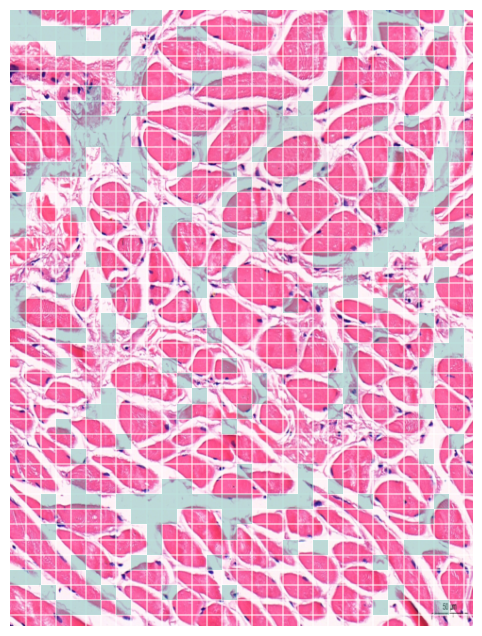

In [9]:
with torch.no_grad():
    img = HENormal.to(dtype).to(device)
    imgTK = model.processImg(img).unsqueeze(1).unsqueeze(1)       #n * 1 * 1 * l1 * d
    imgTK = F.normalize(imgTK,p=2,dim=-1)

    imgLM, raLM = model.generateTarget()    # cls * numTarget * d
    imgLM = imgLM.unsqueeze(2).unsqueeze(0)  #1 * cls * numTarget * 1 * d
    
    distImg = model.computeDist(imgTK,imgLM,model.temperatureImg,returnMidDist=True) #n * cls * numTarget * patchNum
    distImg = distImg * model.imgVotePara.unsqueeze(-1).abs()
    
    gridShapeImg = (16,40,30)#targetNum, HPatchNum, WPatchNum
    plotSelectedPatches(img,distImg,gridShapeImg=gridShapeImg,topKNum=512,clsIdx=0,title='',showTitle=False,save = False,
                       facecolor='#299D8F',alphaRect=0.3)

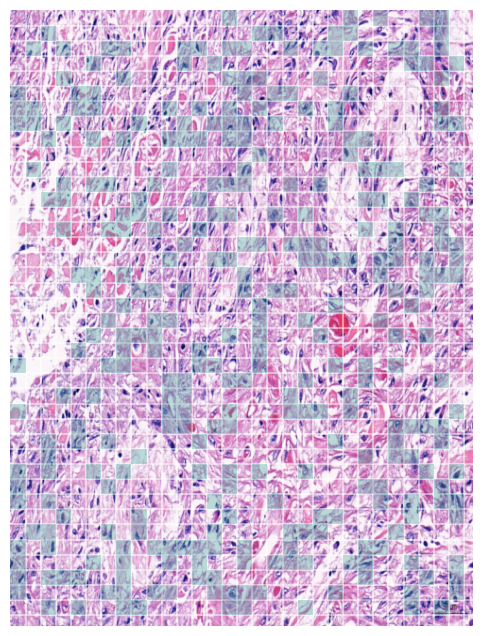

In [10]:
with torch.no_grad():
    img = HETSCC.to(dtype).to(device)
    imgTK = model.processImg(img).unsqueeze(1).unsqueeze(1)       #n * 1 * 1 * l1 * d
    imgTK = F.normalize(imgTK,p=2,dim=-1)

    imgLM, raLM = model.generateTarget()    # cls * numTarget * d
    imgLM = imgLM.unsqueeze(2).unsqueeze(0)  #1 * cls * numTarget * 1 * d
    
    distImg = model.computeDist(imgTK,imgLM,model.temperatureImg,returnMidDist=True) #n * cls * numTarget * patchNum
    distImg = distImg * model.imgVotePara.unsqueeze(-1).abs()
    
    gridShapeImg = (16,40,30)#targetNum, HPatchNum, WPatchNum
    plotSelectedPatches(img,distImg,gridShapeImg=gridShapeImg,topKNum=512,clsIdx=1,title='',showTitle=False,save = False,
                       facecolor='#299D8F',alphaRect=0.3)

Here is the end of this notebook.